In [ ]:
import zipfile
import os

# Define the name of the uploaded file
zip_file_name = '/content/autoencoder_img.zip' # Replace with the name of your zip file

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall('/content/XRAY-Dataset')  # Directory to extract to

Epoch 1/20, Loss: 0.6876
Epoch 2/20, Loss: 0.6743
Epoch 3/20, Loss: 0.6240
Epoch 4/20, Loss: 0.4875
Epoch 5/20, Loss: 0.3684
Epoch 6/20, Loss: 0.3499
Epoch 7/20, Loss: 0.3398
Epoch 8/20, Loss: 0.3300
Epoch 9/20, Loss: 0.3218
Epoch 10/20, Loss: 0.3120
Epoch 11/20, Loss: 0.3028
Epoch 12/20, Loss: 0.2900
Epoch 13/20, Loss: 0.2775
Epoch 14/20, Loss: 0.2685
Epoch 15/20, Loss: 0.2595
Epoch 16/20, Loss: 0.2519
Epoch 17/20, Loss: 0.2432
Epoch 18/20, Loss: 0.2336
Epoch 19/20, Loss: 0.2219
Epoch 20/20, Loss: 0.2072


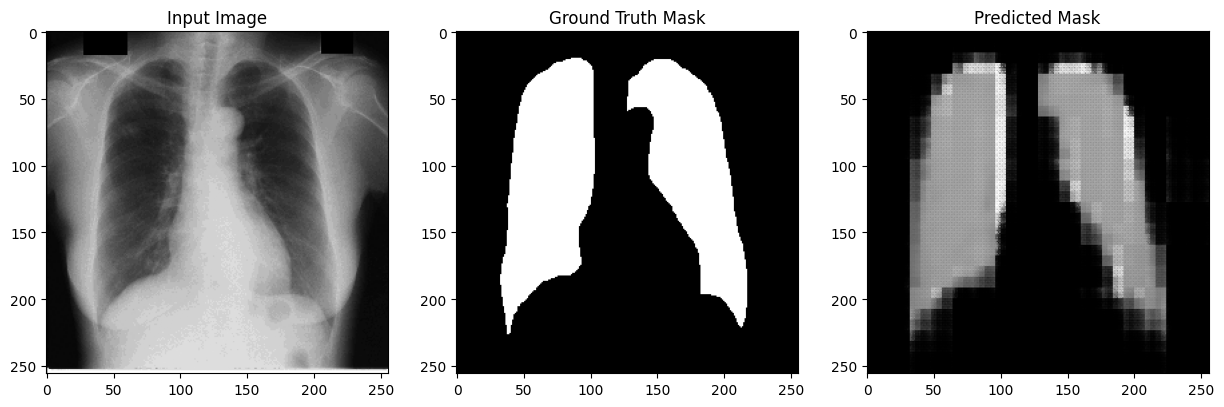

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
import os

# ResNet Backbone U-Net
class ResNet50UNet(nn.Module):
    def __init__(self, n_classes):
        super(ResNet50UNet, self).__init__()
        resnet = models.resnet50(pretrained=True)

        # Encoder: Use ResNet50's layers as feature extractor
        self.encoder1 = nn.Sequential(*list(resnet.children())[:3])  # Conv1 + BN + ReLU
        self.encoder2 = nn.Sequential(*list(resnet.children())[3:5]) # Conv2
        self.encoder3 = resnet.layer2  # Conv3
        self.encoder4 = resnet.layer3  # Conv4
        self.encoder5 = resnet.layer4  # Conv5

        # Decoder: Upsampling with transposed convolutions
        self.up5 = self.up_conv(2048, 1024)
        self.up4 = self.up_conv(1024, 512)
        self.up3 = self.up_conv(512, 256)
        self.up2 = self.up_conv(256, 64)
        self.up1 = self.up_conv(64, 64)

        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    def up_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoding path
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)
        enc4 = self.encoder4(enc3)
        enc5 = self.encoder5(enc4)

        # Decoding path
        dec5 = self.up5(enc5)
        dec4 = self.up4(dec5 + enc4)
        dec3 = self.up3(dec4 + enc3)
        dec2 = self.up2(dec3 + enc2)
        dec1 = self.up1(dec2 + enc1)

        return self.final_conv(dec1)

# Custom dataset for JSRT data
class JSRTDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_filenames = [f for f in os.listdir(image_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.image_filenames[idx])

        image = Image.open(img_path).convert('RGB')  # Convert to RGB for 3 channels
        mask = Image.open(mask_path).convert('RGB')  # Convert mask to RGB as well

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Transformation for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Dataloader for training and validation
train_dataset = JSRTDataset(image_dir='/content/XRAY-Dataset/Segmentation01/train/org', mask_dir='/content/XRAY-Dataset/Segmentation01/train/label', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet50UNet(n_classes=3).to(device)  # Change n_classes to 3
criterion = nn.BCEWithLogitsLoss()  # Use binary cross-entropy for binary masks
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

# Inference (on test set)
def predict(model, image):
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        output = model(image)
        return torch.sigmoid(output).squeeze().cpu().numpy()

# Test on one image (example)
test_image, test_mask = train_dataset[0]
predicted_mask = predict(model, test_image)
predicted_mask = predicted_mask.squeeze()


# Plotting the segmentation result
import matplotlib.pyplot as plt
def plot_segmentation(image, mask, prediction):
    plt.figure(figsize=(15, 5))

    # Change the order for RGB
    plt.subplot(1, 3, 1)
    plt.imshow(image.permute(1, 2, 0).numpy())  # Convert to numpy for imshow
    plt.title('Input Image')

    plt.subplot(1, 3, 2)
    plt.imshow(mask.permute(1, 2, 0).numpy())  # Convert to numpy for imshow
    plt.title('Ground Truth Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(prediction[0], cmap='gray')  # Show predicted mask in grayscale
    plt.title('Predicted Mask')

    plt.show()

plot_segmentation(test_image, test_mask, predicted_mask)


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np

# ResNet Backbone U-Net
class ResNet50UNet(nn.Module):
    def __init__(self, n_classes):
        super(ResNet50UNet, self).__init__()
        resnet = models.resnet50(pretrained=True)

        # Encoder: Use ResNet50's layers as feature extractor
        self.encoder1 = nn.Sequential(*list(resnet.children())[:3])  # Conv1 + BN + ReLU
        self.encoder2 = nn.Sequential(*list(resnet.children())[3:5]) # Conv2
        self.encoder3 = resnet.layer2  # Conv3
        self.encoder4 = resnet.layer3  # Conv4
        self.encoder5 = resnet.layer4  # Conv5

        # Decoder: Upsampling with transposed convolutions
        self.up5 = self.up_conv(2048, 1024)
        self.up4 = self.up_conv(1024, 512)
        self.up3 = self.up_conv(512, 256)
        self.up2 = self.up_conv(256, 64)
        self.up1 = self.up_conv(64, 64)

        self.final_conv = nn.Conv2d(64, n_classes, kernel_size=1)

    def up_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoding path
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)
        enc4 = self.encoder4(enc3)
        enc5 = self.encoder5(enc4)

        # Decoding path
        dec5 = self.up5(enc5)
        dec4 = self.up4(dec5 + enc4)
        dec3 = self.up3(dec4 + enc3)
        dec2 = self.up2(dec3 + enc2)
        dec1 = self.up1(dec2 + enc1)

        return self.final_conv(dec1)

# Custom dataset for JSRT data
class JSRTDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_filenames = [f for f in os.listdir(image_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.image_filenames[idx])

        image = Image.open(img_path).convert('RGB')  # Convert to RGB for 3 channels
        mask = Image.open(mask_path).convert('L')  # Convert mask to grayscale (single channel)

        if self.transform:
            image = self.transform(image)
            mask = transforms.ToTensor()(mask)  # Convert mask to tensor separately

        return image, mask

# Transformation for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Dataloader for training and validation
train_dataset = JSRTDataset(image_dir='/content/XRAY-Dataset/Segmentation01/train/org',
                            mask_dir='/content/XRAY-Dataset/Segmentation01/train/label',
                            transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet50UNet(n_classes=1).to(device)  # n_classes=1 for binary segmentation
criterion = nn.BCEWithLogitsLoss()  # Use binary cross-entropy for binary masks
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Load existing model or train
model_path = 'resnet50_unet_model.pth'
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    print("Loaded existing model.")
else:
    # Training loop
    num_epochs = 50
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    # Save the model after training
    torch.save(model.state_dict(), model_path)

# Inference (on test set)
def predict(model, image):
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        output = model(image)
        output = torch.sigmoid(output)
        predicted_mask = (output > 0.5).float()  # Binarize the prediction
        return predicted_mask.squeeze().cpu().numpy()

# Calculate metrics
def calculate_metrics(pred, target):
    pred = (pred > 0.5).astype(np.uint8)  # Binarize predictions
    target = (target > 0.5).astype(np.uint8)  # Binarize ground truth mask
    intersection = np.logical_and(pred, target).sum()
    total = np.logical_or(pred, target).sum()
    iou = intersection / total if total != 0 else 0
    return iou

# # Test on one image (example)
# test_image, test_mask = train_dataset[0]
# predicted_mask = predict(model, test_image)
# predicted_mask = predicted_mask.squeeze()

# # Calculate accuracy metrics
# test_mask_np = np.array(test_mask.squeeze().numpy() > 0.5, dtype=np.uint8)  # Convert mask to binary
# iou_score = calculate_metrics(predicted_mask, test_mask_np)

# # Print the IoU score
# print(f"IoU Score: {iou_score:.4f}")

# Test Dataset and Dataloader
test_dataset = JSRTDataset(image_dir='/content/XRAY-Dataset/Segmentation01/test/org',
                           mask_dir='/content/XRAY-Dataset/Segmentation01/test/label',
                           transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Inference on the test set
def evaluate_on_test_set(model, test_loader):
    model.eval()
    iou_scores = []

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)

            # Predict the mask
            outputs = model(images)
            outputs = torch.sigmoid(outputs)
            predicted_masks = (outputs > 0.5).float()

            # Calculate IoU for the batch
            predicted_masks_np = predicted_masks.squeeze().cpu().numpy()
            masks_np = masks.squeeze().cpu().numpy()

            iou_score = calculate_metrics(predicted_masks_np, masks_np)
            iou_scores.append(iou_score)

    # Average IoU over the entire test set
    avg_iou = np.mean(iou_scores)
    print(f'Average IoU Score on Test Set: {avg_iou:.4f}')
    return avg_iou

# Evaluate the model on the entire test set
average_iou = evaluate_on_test_set(model, test_loader)


# Plotting the segmentation result
def plot_segmentation(image, mask, prediction):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(image.permute(1, 2, 0).numpy())  # Convert to numpy for imshow
    plt.title('Input Image')

    plt.subplot(1, 3, 2)
    plt.imshow(mask.squeeze(), cmap='gray')  # Convert mask to grayscale
    plt.title('Ground Truth Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(prediction.squeeze(), cmap='gray')  # Show predicted mask in grayscale
    plt.title('Predicted Mask')

    plt.show()

plot_segmentation(test_image, test_mask, predicted_mask)


FileNotFoundError: [Errno 2] No such file or directory: '/content/XRAY-Dataset/Segmentation01/train/org'

In [ ]:
# Initialize variables to store IoU scores for each epoch
iou_scores = []

# Load existing model or train
model_path = 'resnet50_unet_model.pth'
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    print("Loaded existing model.")
else:
    # Training loop
    num_epochs = 50
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, masks in train_loader:
            images = images.to(device)
            masks = masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')

        # Evaluate the model on the test set after each epoch
        avg_iou = evaluate_on_test_set(model, test_loader)
        if avg_iou is not None:  # Check if avg_iou is valid
            iou_scores.append(avg_iou)
            print(f'Average IoU after Epoch {epoch + 1}: {avg_iou:.4f}')
        else:
            print(f'No IoU score calculated for Epoch {epoch + 1}.')

    # Save the model after training
    torch.save(model.state_dict(), model_path)

# After training, check if iou_scores has values before plotting
if len(iou_scores) > 0:
    plot_iou_vs_epochs(iou_scores)
else:
    print("No IoU scores to plot.")


Loaded existing model.
No IoU scores to plot.


<ipython-input-26-ab240ebc248e>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


In [ ]:
!apt-get install tree


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 0s (412 kB/s)
Selecting previously unselected package tree.
(Reading database ... 123621 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
!tree /content/XRAY-Dataset/autoencoder_img

/content/XRAY-Dataset/autoencoder_img
├── abnormal.txt
├── chestCNN_AutoEncoder300epoch.h5
├── chestCNN_Encoder300epoch.h5
├── flip
│   ├── case231.bmp
│   ├── case231.tif
│   ├── case232.bmp
│   ├── case232.tif
│   ├── case233.bmp
│   ├── case233.tif
│   ├── case234.bmp
│   ├── case234.tif
│   ├── case235.bmp
│   ├── case235.tif
│   ├── case236.bmp
│   ├── case236.tif
│   ├── case237.bmp
│   ├── case237.tif
│   ├── case238.bmp
│   ├── case238.tif
│   ├── case239.bmp
│   ├── case239.tif
│   ├── case240.bmp
│   ├── case240.tif
│   ├── case241.bmp
│   ├── case241.tif
│   ├── case242.bmp
│   ├── case242.tif
│   ├── case243.bmp
│   ├── case243.tif
│   ├── case244.bmp
│   ├── case244.tif
│   ├── case245.bmp
│   ├── case245.tif
│   ├── case246.bmp
│   ├── case246.tif
│   ├── case247.bmp
│   └── case247.tif
├── normal
│   ├── case201.bmp
│   ├── case202.bmp
│   ├── case203.bmp
│   ├── case204.bmp
│   ├── case205.bmp
│   ├── case206.bmp
│   ├── case207.bmp
│   ├── case208.bmp
│   ├── case209.b

In [ ]:
import os
import shutil

# Define paths
source_path = '/content/XRAY-Dataset/autoencoder_img'
target_path = '/content/XRAY-Dataset/dataset'

# Create the target directory structure
os.makedirs(os.path.join(target_path, 'train', 'normal200'), exist_ok=True)
os.makedirs(os.path.join(target_path, 'train', 'normal'), exist_ok=True)
os.makedirs(os.path.join(target_path, 'train', 'flip'), exist_ok=True)
os.makedirs(os.path.join(target_path, 'test', 'normal'), exist_ok=True)
os.makedirs(os.path.join(target_path, 'test', 'flip'), exist_ok=True)

# Copy normal200 images to the appropriate training directory
normal200_path = os.path.join(source_path, 'normal200')
for img in os.listdir(normal200_path):
    shutil.copy(os.path.join(normal200_path, img), os.path.join(target_path, 'train', 'normal200', img))

# Copy normal images to the appropriate training directory
normal_path = os.path.join(source_path, 'normal')
for img in os.listdir(normal_path):
    shutil.copy(os.path.join(normal_path, img), os.path.join(target_path, 'train', 'normal', img))

# Copy flipped images to the appropriate training directory
flip_path = os.path.join(source_path, 'flip')
for img in os.listdir(flip_path):
    shutil.copy(os.path.join(flip_path, img), os.path.join(target_path, 'train', 'flip', img))

# Copy random normal images to the test folder for evaluation
# Here we copy a specific number of normal images to the test directories
num_test_images = 10  # Number of images to copy for testing

# Copy from normal200 to test
for img in os.listdir(normal200_path)[:num_test_images]:
    shutil.copy(os.path.join(normal200_path, img), os.path.join(target_path, 'test', 'normal', img))

# Copy from normal to test
for img in os.listdir(normal_path)[:num_test_images]:
    shutil.copy(os.path.join(normal_path, img), os.path.join(target_path, 'test', 'normal', img))

# Copy from flip to test
for img in os.listdir(flip_path)[:num_test_images]:
    shutil.copy(os.path.join(flip_path, img), os.path.join(target_path, 'test', 'flip', img))

print("Directory structure transformed successfully, and images copied to test folders!")


Directory structure transformed successfully, and images copied to test folders!


In [ ]:
!pip install anomalib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 425.0/425.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.5/208.5 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 kB 26.8 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=723f0a0fe26e821458de873beb0180c05c0af6eaf4069e46c5409688ef38ea3d
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


In [ ]:
import os
import shutil

# Define source directories
train_dir = '/content/XRAY-Dataset/autoencoder_img/normal200'
test_dir = '/content/XRAY-Dataset/autoencoder_img/flip'

# Define destination directories
train_dest = '/content/XRAY-Dataset/dataset/train/'
test_dest = '/content/XRAY-Dataset/dataset/test/'

# Create destination directories
os.makedirs(train_dest, exist_ok=True)
os.makedirs(test_dest, exist_ok=True)

# Move training images
for filename in os.listdir(train_dir):
    shutil.copy(os.path.join(train_dir, filename), train_dest)

# Move test images
for filename in os.listdir(test_dir):
    shutil.copy(os.path.join(test_dir, filename), test_dest)


In [ ]:
# Import the required modules from Anomalib
from anomalib.data.mvtec import MVTec
from anomalib.models import Patchcore
from anomalib.engine import AnomalyTrainer

# Initialize the dataset (MVTec) and model (Patchcore with ResNet-50 backbone)
datamodule = MVTec(root='/content/data', category="bottle")  # Change category based on your use case
model = Patchcore(backbone="resnet50")  # Set the backbone to ResNet-50

# Initialize the trainer
trainer = AnomalyTrainer(model=model, datamodule=datamodule)

# Train the model
trainer.fit()

# Evaluate the model
results = trainer.test()
print("Evaluation Results:")
print(results)


ModuleNotFoundError: No module named 'anomalib.data.mvtec'

In [ ]:
!pip install anomalib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 425.0/425.0 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.5/208.5 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 kB 34.0 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=dbe85bae3de04b8f7112c041648acb6d7eda2a5f70ff580781be3c070b88d454
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


In [ ]:
import anomalib
print("Anomalib version:", anomalib.__version__)


Anomalib version: 1.1.1


In [ ]:
!git clone https://github.com/openvinotoolkit/anomalib.git


Cloning into 'anomalib'...
remote: Enumerating objects: 11795, done.
remote: Counting objects: 100% (1313/1313), done.
remote: Compressing objects: 100% (913/913), done.
remote: Total 11795 (delta 631), reused 807 (delta 345), pack-reused 10482 (from 1)
Receiving objects: 100% (11795/11795), 67.30 MiB | 28.62 MiB/s, done.
Resolving deltas: 100% (6995/6995), done.


In [ ]:
pip install anomalib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 425.0/425.0 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.5/208.5 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 kB 27.2 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=1312cdc20b84df6ee817bf64cf18615857404640a2e4f00e0eed9325eb3965f7
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


In [ ]:
import os
import shutil

# Define paths
source_path = '/content/XRAY-Dataset/autoencoder_img'
target_path = '/content/XRAY-Dataset/dataset'

# Create the target directory structure
os.makedirs(os.path.join(target_path, 'train', 'normal200', 'normal'), exist_ok=True)
os.makedirs(os.path.join(target_path, 'train', 'normal', 'normal'), exist_ok=True)
os.makedirs(os.path.join(target_path, 'train', 'flip', 'flipped'), exist_ok=True)
os.makedirs(os.path.join(target_path, 'test', 'normal', 'normal'), exist_ok=True)
os.makedirs(os.path.join(target_path, 'test', 'flip', 'flipped'), exist_ok=True)

# Move normal200 images to the appropriate directory
normal200_path = os.path.join(source_path, 'normal200')
for img in os.listdir(normal200_path):
    shutil.copy(os.path.join(normal200_path, img), os.path.join(target_path, 'train', 'normal200', 'normal', img))

# Move normal images to the appropriate directory
normal_path = os.path.join(source_path, 'normal')
for img in os.listdir(normal_path):
    shutil.copy(os.path.join(normal_path, img), os.path.join(target_path, 'train', 'normal', 'normal', img))

# Move flipped images to the appropriate directory
flip_path = os.path.join(source_path, 'flip')
for img in os.listdir(flip_path):
    shutil.copy(os.path.join(flip_path, img), os.path.join(target_path, 'train', 'flip', 'flipped', img))

# Optionally copy some images to the test folders
# Here we just copy a random selection of images for demonstration
num_test_images = 10  # Adjust this number based on your needs

# Copy images to test from normal200
for img in os.listdir(os.path.join(target_path, 'train', 'normal200', 'normal'))[:num_test_images]:
    shutil.copy(os.path.join(target_path, 'train', 'normal200', 'normal', img), os.path.join(target_path, 'test', 'normal', 'normal', img))

# Copy images to test from normal
for img in os.listdir(os.path.join(target_path, 'train', 'normal', 'normal'))[:num_test_images]:
    shutil.copy(os.path.join(target_path, 'train', 'normal', 'normal', img), os.path.join(target_path, 'test', 'normal', 'normal', img))

# Copy images to test from flip
for img in os.listdir(os.path.join(target_path, 'train', 'flip', 'flipped'))[:num_test_images]:
    shutil.copy(os.path.join(target_path, 'train', 'flip', 'flipped', img), os.path.join(target_path, 'test', 'flip', 'flipped', img))

print("Directory structure transformed successfully!")


Directory structure transformed successfully!


In [ ]:
import os
import shutil

# Define the source dataset path
source_dataset_path = '/content/XRAY-Dataset/autoencoder_img/'

# Create a new dataset directory
os.makedirs('/content/XRAY-Dataset/dataset/train/class1', exist_ok=True)
os.makedirs('/content/XRAY-Dataset/dataset/train/class2', exist_ok=True)
os.makedirs('/content/XRAY-Dataset/dataset/test/class1', exist_ok=True)
os.makedirs('/content/XRAY-Dataset/dataset/test/class2', exist_ok=True)

# Move files to the respective directories (example)
# Assuming 'normal' images are class1 and 'flip' images are class2
for img in os.listdir(os.path.join(source_dataset_path, 'normal')):
    shutil.copy(os.path.join(source_dataset_path, 'normal', img), '/content/XRAY-Dataset/dataset/train/class1/')

for img in os.listdir(os.path.join(source_dataset_path, 'flip')):
    shutil.copy(os.path.join(source_dataset_path, 'flip', img), '/content/XRAY-Dataset/dataset/test/class2/')


In [ ]:
import shutil

# Replace 'your_directory_path' with the path to the directory you want to delete
shutil.rmtree('/content/XRAY-Dataset/dataset')


In [ ]:
# Install necessary packages
!pip install anomalib
!pip install lightning
!pip install open_clip_torch

# Import necessary libraries
import os
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from anomalib.models import Patchcore
from anomalib.engine import Engine

# Specify paths to your dataset
train_data_path = '/content/XRAY-Dataset/dataset/train'  # Path to training data
test_data_path = '/content/XRAY-Dataset/dataset/test'    # Path to test data

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256 as specified
    transforms.ToTensor()            # Convert images to tensor
])

# Load datasets using ImageFolder for training
train_normal200_dataset = datasets.ImageFolder(root=os.path.join(train_data_path, 'normal200'), transform=transform)
train_normal_dataset = datasets.ImageFolder(root=os.path.join(train_data_path, 'normal'), transform=transform)
train_flip_dataset = datasets.ImageFolder(root=os.path.join(train_data_path, 'flip'), transform=transform)

# Combine normal and flipped datasets for training
train_dataset = torch.utils.data.ConcatDataset([train_normal200_dataset, train_normal_dataset, train_flip_dataset])

# Create DataLoader for training
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Load test datasets
test_normal_dataset = datasets.ImageFolder(root=os.path.join(test_data_path, 'normal'), transform=transform)
test_flip_dataset = datasets.ImageFolder(root=os.path.join(test_data_path, 'flip'), transform=transform)

# Create DataLoader for testing
test_loader = DataLoader(test_normal_dataset, batch_size=16, shuffle=False)
test_flip_loader = DataLoader(test_flip_dataset, batch_size=16, shuffle=False)

# Initialize the Patchcore model with ResNet-50 backbone
model = Patchcore(backbone='resnet50')

# Initialize the Engine
engine = Engine()

# Train the model
engine.fit(train_dataloader=train_loader, model=model)

# Evaluate the model on normal and flip test datasets
normal_evaluation_results = engine.test(test_dataloader=test_loader, model=model)
flip_evaluation_results = engine.test(test_dataloader=test_flip_loader, model=model)

# Print evaluation results for both datasets
print("Normal Evaluation Results:", normal_evaluation_results)
print("Flip Evaluation Results:", flip_evaluation_results)


FileNotFoundError: Couldn't find any class folder in /content/XRAY-Dataset/dataset/train/normal200.

In [ ]:
!pip install FrEIA

  Preparing metadata (setup.py) ... done
  Created wheel for FrEIA: filename=FrEIA-0.2-py3-none-any.whl size=42761 sha256=6c8553b12ada5959ae06ce1ddc960339b170e9a66abf0b4dfc796a3ca4105cdb
  Stored in directory: /root/.cache/pip/wheels/81/a8/e2/d532a76f72108ac4a340cbe3f86b4f591abfdbd75209a5badb
Successfully built FrEIA


In [ ]:
# Install necessary packages
!pip install anomalib
!pip install lightning
!pip install open_clip_torch

# Import necessary libraries
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from anomalib.models import Patchcore
from anomalib.engine import Engine
from lightning.pytorch import LightningDataModule  # Correct import for LightningDataModule

# Specify paths to your dataset
train_data_path = '/content/XRAY-Dataset/dataset/train'  # Path to training data
test_data_path = '/content/XRAY-Dataset/dataset/test'    # Path to test data

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256 as specified
    transforms.ToTensor()            # Convert images to tensor
])

# Custom Dataset Wrapper
class CustomImageFolder(Dataset):
    def __init__(self, root, transform=None):
        self.dataset = datasets.ImageFolder(root=root, transform=transform)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image, label = self.dataset[index]
        return {"image": image, "label": label}  # Return a dict

# Custom DataModule class inheriting from LightningDataModule
class CustomDataModule(LightningDataModule):
    def __init__(self, train_data_path, test_data_path, transform, batch_size=16):
        super().__init__()
        self.train_data_path = train_data_path
        self.test_data_path = test_data_path
        self.transform = transform
        self.batch_size = batch_size
               # Keep required attributes
        self.name = "CustomDataModule"
        self.category = "anomaly_detection"

    def setup(self, stage=None):
        # Initialize datasets
        self.train_dataset = CustomImageFolder(root=self.train_data_path, transform=self.transform)
        self.test_dataset = CustomImageFolder(root=self.test_data_path, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)

# Initialize the custom data module with the transformation
data_module = CustomDataModule(train_data_path, test_data_path, transform)

# Initialize the Patchcore model with ResNet-50 backbone
model = Patchcore(backbone='resnet50')

# Initialize the Engine
engine = Engine()

# Train the model using the DataModule
engine.fit(datamodule=data_module, model=model)

# Evaluate the model on test datasets
normal_evaluation_results = engine.test(test_dataloader=data_module.test_dataloader(), model=model)

# Print evaluation results for the normal dataset
print("Normal Evaluation Results:", normal_evaluation_results)


INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:lightning.pytorch.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.rich_model_summary.RichModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


┏━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name                  ┃ Type                     ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model                 │ PatchcoreModel           │  8.5 M │ train │
│ 1 │ normalization_metrics │ MetricCollection         │      0 │ train │
│ 2 │ image_threshold       │ F1AdaptiveThreshold      │      0 │ train │
│ 3 │ pixel_threshold       │ F1AdaptiveThreshold      │      0 │ train │
│ 4 │ image_metrics         │ AnomalibMetricCollection │      0 │ train │
│ 5 │ pixel_metrics         │ AnomalibMetricCollection │      0 │ train │
└───┴───────────────────────┴──────────────────────────┴────────┴───────┘

Trainable params: 8.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 8.5 M                                                                                                
Total estimated model params size (MB): 34                                                                         
Modules in train mode: 16                                                                                          
Modules in eval mode: 174

Output()

Output()

In [ ]:
!pip install open_clip_torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.5 MB/s eta 0:00:00


In [ ]:
# Install necessary packages (adjust based on your environment)
!pip install anomalib
!pip install lightning
!pip install tensorflow

# Import necessary libraries
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from anomalib.engine import Engine  # Optional, if using
from lightning.pytorch import LightningDataModule  # For DataModule management
import tensorflow as tf  # For loading the Keras model
import numpy as np

# Load the pre-trained autoencoder model (chestcnnautoencoder.nh5)
autoencoder = tf.keras.models.load_model('')

# Specify paths to your dataset
train_data_path = '/content/XRAY-Dataset/dataset/train'  # Path to training data
test_data_path = '/content/XRAY-Dataset/dataset/test'    # Path to test data

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256 as specified
    transforms.ToTensor()            # Convert images to tensor
])

# Custom Dataset Wrapper
class CustomImageFolder(Dataset):
    def __init__(self, root, transform=None):
        self.dataset = datasets.ImageFolder(root=root, transform=transform)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image, label = self.dataset[index]
        return {"image": image, "label": label}  # Return a dictionary

# Custom DataModule class inheriting from LightningDataModule
class CustomDataModule(LightningDataModule):
    def __init__(self, train_data_path, test_data_path, transform, batch_size=16):
        super().__init__()
        self.train_data_path = train_data_path
        self.test_data_path = test_data_path
        self.transform = transform
        self.batch_size = batch_size

    def setup(self, stage=None):
        # Initialize datasets
        self.train_dataset = CustomImageFolder(root=self.train_data_path, transform=self.transform)
        self.test_dataset = CustomImageFolder(root=self.test_data_path, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)

# Initialize the custom data module with the transformation
data_module = CustomDataModule(train_data_path, test_data_path, transform)

# Function to run the autoencoder on test data and calculate reconstruction error
def test_autoencoder(autoencoder, dataloader):
    reconstruction_errors = []
    for batch in dataloader:
        images = batch["image"].numpy()
        # Rescale to [0,1] if needed
        images = images.transpose(0, 2, 3, 1)  # Convert to (batch, height, width, channels) for TensorFlow

        # Normalize image if necessary
        images = images / 255.0

        # Run the images through the autoencoder
        reconstructed_images = autoencoder.predict(images)

        # Compute reconstruction error
        errors = np.mean(np.square(images - reconstructed_images), axis=(1, 2, 3))  # Mean squared error
        reconstruction_errors.extend(errors)

    return reconstruction_errors

# Run the evaluation
test_loader = data_module.test_dataloader()

# Evaluate using autoencoder
reconstruction_errors = test_autoencoder(autoencoder, test_loader)

# Set a threshold for anomaly detection (You may need to experiment with this value)
threshold = 0.05  # Example threshold

# Classify images as normal or anomalous based on reconstruction error
anomalies = [error > threshold for error in reconstruction_errors]

# Print the evaluation results
print("Reconstruction Errors:", reconstruction_errors)
print("Anomalies Detected:", anomalies)


/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


ValueError: Argument(s) not recognized: {'lr': 0.0010000000474974513}

In [ ]:
# Install necessary packages
!pip install torch torchvision scikit-learn

# Import necessary libraries
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
import numpy as np
import os
import matplotlib.pyplot as plt

# Load the pre-trained ResNet-50 model
resnet50 = models.resnet50(pretrained=True)
# Remove the final classification layer to use ResNet as a feature extractor
resnet50 = nn.Sequential(*list(resnet50.children())[:-1])
resnet50.eval()  # Set the model to evaluation mode

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ResNet expects normalized images
])

# Custom Dataset Wrapper for loading images based on text files
class CustomImageFolder(Dataset):
    def __init__(self, root, normal_file, abnormal_file, transform=None):
        self.root = root
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Load normal images
        with open(normal_file, 'r') as f:
            for line in f:
                filename = line.strip()
                self.image_paths.append(os.path.join(root, 'normal', filename))
                self.labels.append(0)  # 0 for normal

        # Load abnormal images
        with open(abnormal_file, 'r') as f:
            for line in f:
                filename = line.strip()
                self.image_paths.append(os.path.join(root, 'abnormal', filename))
                self.labels.append(1)  # 1 for abnormal

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.labels[index]
        image = datasets.folder.default_loader(image_path)  # Load the image
        if self.transform:
            image = self.transform(image)
        return {"image": image, "label": label}

# Paths to your dataset
dataset_path = '/content/XRAY-Dataset/autoencoder_img'
normal_file = os.path.join(dataset_path, 'normal.txt')
abnormal_file = os.path.join(dataset_path, 'abnormal.txt')

# Create the dataset
dataset = CustomImageFolder(root=dataset_path, normal_file=normal_file, abnormal_file=abnormal_file, transform=transform)

# Create DataLoader for the dataset
data_loader = DataLoader(dataset, batch_size=16, shuffle=False)

# Function to extract features using ResNet-50
def extract_features(loader, model):
    features = []
    labels = []
    with torch.no_grad():
        for batch in loader:
            images = batch["image"]
            labels.extend(batch["label"])  # Store labels
            features_batch = model(images).squeeze()  # Extract features
            features.extend(features_batch.numpy())
    return np.array(features), np.array(labels)

# Extract features from the dataset
features, labels = extract_features(data_loader, resnet50)

### Task 8: Anomaly Detection ###
# Use Isolation Forest for anomaly detection
isolation_forest = IsolationForest(contamination=0.1)  # Adjust contamination rate based on your data
isolation_forest.fit(features)

# Predict anomalies
anomalies = isolation_forest.predict(features)  # -1 indicates anomaly, 1 indicates normal

# Print anomaly detection results
print(f"Anomalies detected: {np.sum(anomalies == -1)} out of {len(anomalies)} images")

### Task 9: Unsupervised Clustering ###
# Use K-means clustering
n_clusters = 2  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(features)

# Predict clusters
clusters = kmeans.predict(features)

# Print cluster assignment
print(f"Cluster assignments: {clusters}")

# Example: Visualize how images are grouped into clusters
plt.scatter(features[:, 0], features[:, 1], c=clusters, cmap='viridis')
plt.title("K-means clustering of chest X-rays")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/content/XRAY-Dataset/autoencoder_img/normal/filenames'